# Calculating ROI for 3 bedroom houses (1 year)
- ROI = Return on Investment
- How much average profit to expect as (% growth) after expenses.
- Expenses:  mortgage, closing costs, property taxes and upgrades.
- DataSource: Zillow 3-Bedroom Time Series

### Summary:
As a real estate investor, I need to invest 12M dollars in the most profitable areas maximizing my profits by ROI.  My findings are listed below and answer the question of what are the best returns available in the market at this time.

In [1]:
# Imports
import pandas as pd     # Used for handling and manipulating structured data in DataFrames and Series
import numpy as np      # Used for numerical computations and handling arrays efficiently
# These are used for machine learning tasks:
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.preprocessing import PolynomialFeatures  # Generating polynomial features for regression
from sklearn.linear_model import LinearRegression     # Applying linear regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # Evaluating regression performance
import locale                                      # Used for setting locale-specific formatting for numbers, currencies, etc.
import warnings                                    # Used for filtering and suppressing warning messages during execution
# These are used for geospatial data analysis and visualization:
import geopandas as gpd                            # Handling geospatial data in DataFrames
import matplotlib.pyplot as plt                    # Plotting static visualizations
from IPython.display import display, HTML          # Displaying outputs and HTML in Jupyter environments
from matplotlib.colors import TwoSlopeNorm         # Normalizing color maps for diverging scales in matplotlib

# Used for interactive heat maps
import folium                                      # Creating interactive maps
from folium import Choropleth                      # Adding choropleth layers for color-coded maps
import branca.colormap as cm                       # Creating and managing color maps for visualizations


# Sourced from Zillow - https://www.zillow.com/research/data/
df = pd.read_csv("Data/3bedroom_zip.csv")

# Sourced from ChatGPT
tax_rates = pd.read_csv('Data/property_tax_rates.csv')

# Merge df with property tax_rates by state with zillow home data
df = df.merge(tax_rates[['State_of Tax', '2024']], 
              left_on='StateName', 
              right_on='State_of Tax', 
              how='left')

# Drop the redundant 'State_of Tax' column from tax_rates if needed
df = df.drop(columns=['State_of Tax'])

# Rename the column to Property_Tax
df.rename(columns={'2024' : 'Property_Tax'}, inplace=True)

# Convert 'Property_Tax' column to float 
df['Property_Tax'] = df['Property_Tax'].str.rstrip('%').astype(float)
# list(df.dtypes.items())

### Data Cleaning & EDA (Exploratory Data Analysis)
- Examine and understand the datasets
- Decide what to do with missing values
- Identify and remove duplicates
- Keep relevant columns and delete others

In [2]:
# Remove missing values (NaN)
df = df.dropna() 
# print(df.isnull().sum())

# Dropping columns
df = df.drop(['RegionID', 'SizeRank', 'RegionType', 'Metro'], axis=1)

# Dropping duplicate rows
duplicate_rows_df = df[df.duplicated()]
# print("number of duplicate rows: ", duplicate_rows_df.shape)
df = df.drop_duplicates()

### Feature Engineering
- Summarize monthly dates and values into quarters
- Create 5-year rolling average for home price growth
- Predict future housing values using the 5 years rolling average growth of housing prices

In [3]:
# Convert column names in df to datetime where possible
date_columns = [col for col in df.columns if not pd.isna(pd.to_datetime(col, errors='coerce'))]

# Filter out non-date columns
non_date_columns = [col for col in df.columns if col not in date_columns]

# Create a new DataFrame with only date columns
date_df = df[date_columns]

# Convert column names to datetime and format to only include date
date_df.columns = pd.to_datetime(date_df.columns)

# Resample the data to quarterly frequency and calculate the mean
quarterly_df = date_df.T.resample('QE').mean().T

# Convert the columns to short date format 
quarterly_df.columns = [col.strftime('%Y-%m-%d') for col in quarterly_df.columns]

# # Combine the non-date columns with the quarterly data
df_combined1 = pd.concat([df[non_date_columns], quarterly_df], axis=1)


**Create 5-year rolling average for home price growth**

In [4]:
# Convert column names to datetime where possible
date_columns = [col for col in df_combined1.columns if not pd.isna(pd.to_datetime(col, errors='coerce'))]

# Get the last 20 columns (5 years of quarterly data)
last_20_date_columns = date_columns[-20:]

# Ensure the columns are matched against df_combined1
matched_columns = [col for col in last_20_date_columns if col in df_combined1.columns]

# Transpose the DataFrame for rolling operation along columns
# Each rows 5-year rolling average home price 
df_combined1['5yr_avg'] = (
    df_combined1[matched_columns]
    .T.rolling(window=20, min_periods=20)
    .mean()
    .T.iloc[:, -1]
)

# Use the last column (2024-12-31) as the final value for growth calculation
final_column = last_20_date_columns[-1]  # Should correspond to '2024-12-31'

# Compute Growth_% as (final_value - 5yr_avg) / 5yr_avg)
# Each row has a growth % XX.xx
df_combined1['Growth_%'] = (
    (df_combined1[final_column] - df_combined1['5yr_avg']) / df_combined1['5yr_avg']
) * 100

# Drop rows with missing Growth_% values (if any)
df_combined1 = df_combined1.dropna(subset=['Growth_%'])

# Sort by Growth_% in descending order
df_combined1_sorted = df_combined1.sort_values(by='Growth_%', ascending=False)

**Predict future housing values using the three years rolling average growth of housing prices**

In [5]:
# Calculate future1yr using Growth_%
df_combined1['future1yr'] = (df_combined1[final_column] * (1 + df_combined1['Growth_%'] / 100)).round(2)

# Calculate future2yr based on future1yr and Growth_%
df_combined1['future2yr'] = (df_combined1['future1yr'] * (1 + df_combined1['Growth_%'] / 100)).round(2)

# Calculate future3yr based on future2yr and Growth_%
df_combined1['future3yr'] = (df_combined1['future2yr'] * (1 + df_combined1['Growth_%'] / 100)).round(2)

# Sort the DataFrame by average  in descending order 
df_combined1 = df_combined1.sort_values(by='future1yr', ascending=False)
df1 = df_combined1

### State growth averages before expenses

In [6]:
# Set locale to format numbers as currency in US dollars
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Function to format numbers as currency
def format_currency(value):
    return locale.currency(value, grouping=True)

# Function to format numbers with two decimal places
def format_two_decimals(value):
    return f"{value:.2f}"

# List of columns to calculate averages for
columns_of_interest = ['2020-12-31', '2021-12-31', '2022-12-31', '2023-12-31', '2024-12-31']

# Group by 'State' and calculate the average for each specified column
state_averages = df1.groupby('State')[columns_of_interest].mean().reset_index()

# Add a column for average Growth%
state_averages['Growth_%'] = df1.groupby('State')['Growth_%'].mean().values

# Rename date columns
rename_map = {
    '2020-12-31': '2020',
    '2021-12-31': '2021',
    '2022-12-31': '2022',
    '2023-12-31': '2023',
    '2024-12-31': '2024'
}
state_averages.rename(columns=rename_map, inplace=True)

# Sort to find the top 5 and bottom 5 states by Growth_%
top_5_states = state_averages.sort_values(by='Growth_%', ascending=False).head(5)
bottom_5_states = state_averages.sort_values(by='Growth_%').head(5)

# Format the specified columns as currency with two decimal places
currency_columns = ['2020', '2021', '2022', '2023', '2024', 'Growth_%']
top_5_states[currency_columns] = top_5_states[currency_columns].apply(lambda x: x.map(lambda y: format_currency(float(format_two_decimals(y)))))
bottom_5_states[currency_columns] = bottom_5_states[currency_columns].apply(lambda x: x.map(lambda y: format_currency(float(format_two_decimals(y)))))

# Style the tables with increased column width
styled_top_5 = top_5_states.style.hide(axis='index').set_table_styles(
    [{'selector': 'th', 'props': [('width', '100px')]},  # Double the column width
     {'selector': 'td', 'props': [('width', '100px')]}]
)

styled_bottom_5 = bottom_5_states.style.hide(axis='index').set_table_styles(
    [{'selector': 'th', 'props': [('width', '100px')]},
     {'selector': 'td', 'props': [('width', '100px')]}]
)

# Display Top 5 States Table
display(HTML("<div style='text-align: left; margin-bottom: 15px;'><h3 style='font-weight: bold;'>Top 5 States by Growth_%</h3></div>"))
display(styled_top_5)

# Display Bottom 5 States Table
display(HTML("<div style='text-align: left; margin-top: 30px; margin-bottom: 15px;'><h3 style='font-weight: bold;'>Bottom 5 States by Growth_%</h3></div>"))
display(styled_bottom_5)


State,2020,2021,2022,2023,2024,Growth_%
NH,"$339,126.89","$399,051.69","$456,900.39","$494,593.55","$525,386.35",$22.59
NJ,"$371,765.62","$430,827.11","$469,755.99","$507,583.54","$548,744.63",$22.52
CT,"$281,359.89","$326,306.45","$362,364.77","$396,388.94","$421,950.02",$22.21
SC,"$252,607.83","$307,561.16","$363,777.45","$385,291.34","$405,809.71",$20.42
RI,"$352,854.02","$413,166.49","$457,804.31","$489,605.90","$521,372.19",$20.20


State,2020,2021,2022,2023,2024,Growth_%
LA,"$242,337.24","$267,830.88","$281,677.65","$269,837.23","$264,312.23",$1.37
AK,"$325,410.48","$339,020.34","$354,726.24","$366,082.16","$372,896.65",$6.97
MN,"$302,793.30","$340,680.77","$359,419.48","$364,107.08","$368,264.40",$7.88
OR,"$401,235.39","$477,589.65","$506,861.04","$508,002.56","$514,750.49",$9.20
CO,"$438,911.09","$519,609.49","$567,711.08","$565,119.91","$573,733.03",$9.22


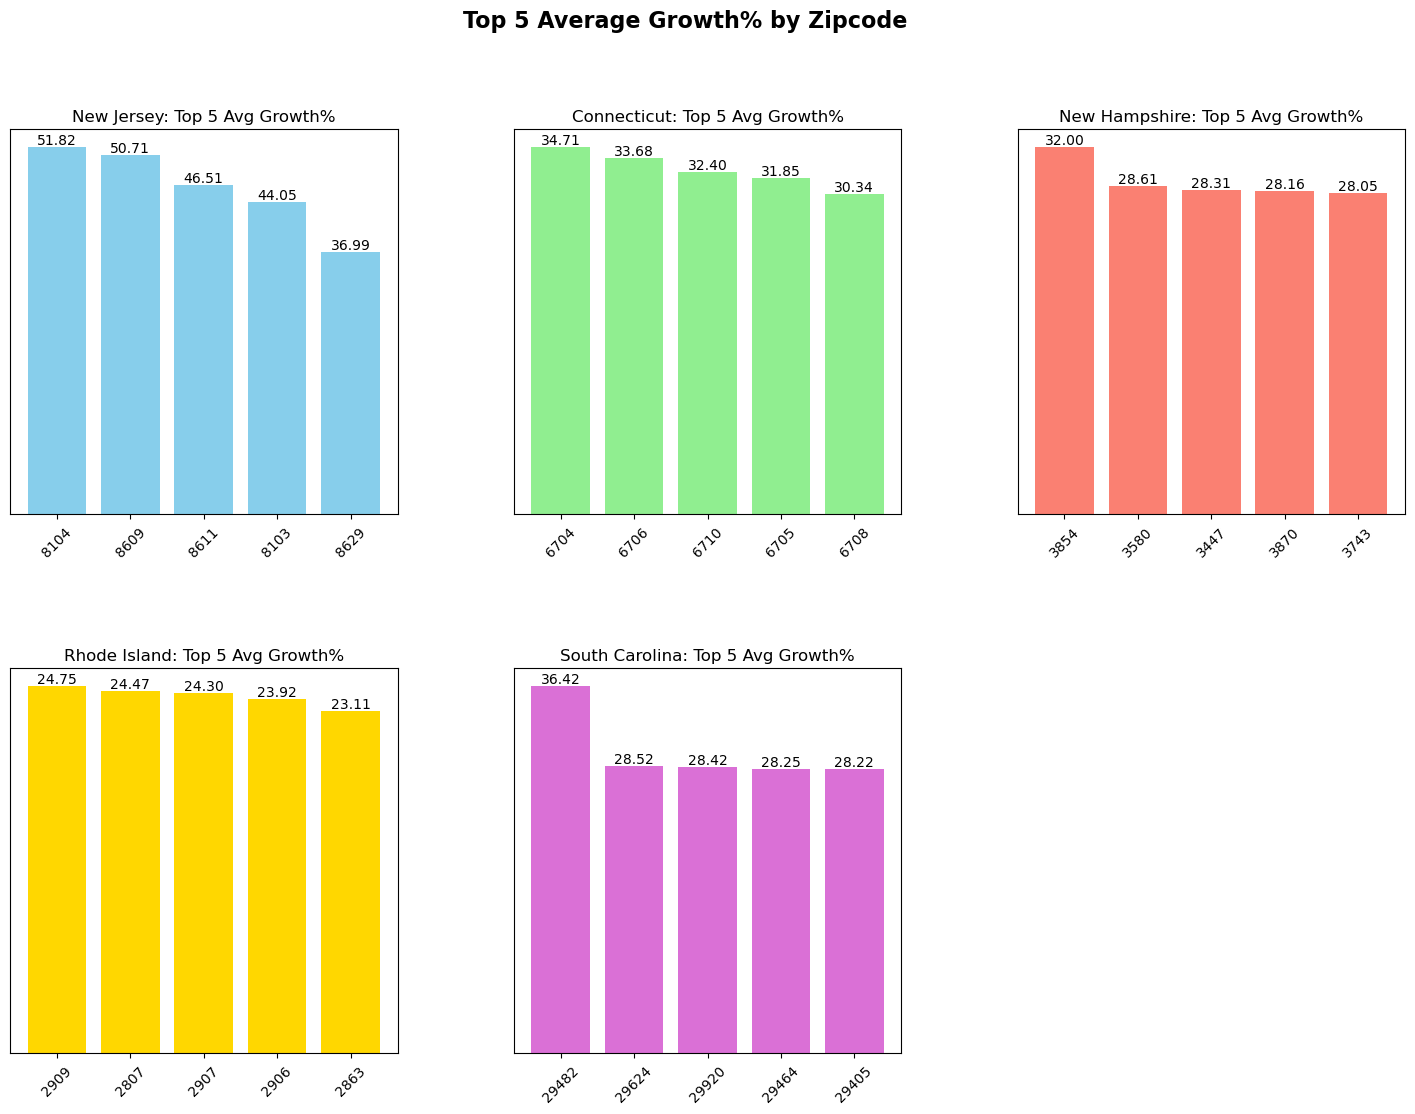

In [7]:
# 'Top 5 Average Growth% by Zipcode

# Ignore DeprecationWarning related to groupby.apply
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Filter df1 for the states of interest
states_of_interest = ['NJ', 'CT', 'NH', 'RI', 'SC']
filtered_df = df1[df1['State'].isin(states_of_interest)].copy()

# Ensure 'RegionName' is treated as a string and clean it
filtered_df['RegionName'] = filtered_df['RegionName'].fillna("").astype(str).str.strip()

# Group by 'State' and 'RegionName' to calculate the average Growth%
grouped_df = filtered_df.groupby(['State', 'RegionName'], as_index=False)['Growth_%'].mean()

# Get the top 5 RegionName by Growth% for each state
top_5_per_state = (
    grouped_df.groupby('State', group_keys=True)
    .apply(lambda x: x.nlargest(5, 'Growth_%'))  # Get top 5 by 'Growth%' for each state
    .reset_index(drop=True)  # Reset index for clean output
)

# Split the data by state
data_nj = top_5_per_state[top_5_per_state['State'] == 'NJ']
data_ct = top_5_per_state[top_5_per_state['State'] == 'CT']
data_nh = top_5_per_state[top_5_per_state['State'] == 'NH']
data_ri = top_5_per_state[top_5_per_state['State'] == 'RI']
data_sc = top_5_per_state[top_5_per_state['State'] == 'SC']

# Create the figure and axes for side-by-side bar charts
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Adjust spacing
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Function to add labels above bars
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

# Function to remove y-axis ticks
def remove_y_ticks(ax):
    ax.tick_params(axis='y', left=False, labelleft=False)

# Plot NJ, CT, NH (3 side-by-side on the first row)
bars_nj = axs[0, 0].bar(data_nj['RegionName'], data_nj['Growth_%'], color='skyblue')
axs[0, 0].set_title('New Jersey: Top 5 Avg Growth%', fontsize=12)
axs[0, 0].tick_params(axis='x', rotation=45)
remove_y_ticks(axs[0, 0])
add_labels(axs[0, 0], bars_nj)

bars_ct = axs[0, 1].bar(data_ct['RegionName'], data_ct['Growth_%'], color='lightgreen')
axs[0, 1].set_title('Connecticut: Top 5 Avg Growth%', fontsize=12)
axs[0, 1].tick_params(axis='x', rotation=45)
remove_y_ticks(axs[0, 1])
add_labels(axs[0, 1], bars_ct)

bars_nh = axs[0, 2].bar(data_nh['RegionName'], data_nh['Growth_%'], color='salmon')
axs[0, 2].set_title('New Hampshire: Top 5 Avg Growth%', fontsize=12)
axs[0, 2].tick_params(axis='x', rotation=45)
remove_y_ticks(axs[0, 2])
add_labels(axs[0, 2], bars_nh)

# Plot RI, SC (2 side-by-side on the second row)
bars_ri = axs[1, 0].bar(data_ri['RegionName'], data_ri['Growth_%'], color='gold')
axs[1, 0].set_title('Rhode Island: Top 5 Avg Growth%', fontsize=12)
axs[1, 0].tick_params(axis='x', rotation=45)
remove_y_ticks(axs[1, 0])
add_labels(axs[1, 0], bars_ri)

bars_sc = axs[1, 1].bar(data_sc['RegionName'], data_sc['Growth_%'], color='orchid')
axs[1, 1].set_title('South Carolina: Top 5 Avg Growth%', fontsize=12)
axs[1, 1].tick_params(axis='x', rotation=45)
remove_y_ticks(axs[1, 1])
add_labels(axs[1, 1], bars_sc)

# Remove the last empty subplot
fig.delaxes(axs[1, 2])

# Add a global title
plt.suptitle('Top 5 Average Growth% by Zipcode', fontsize=16, fontweight='bold')

# Show the plots
plt.show()

### Calculate Profit ROI (Sale price - total_cost_1yr) / Purchase price) 
- upgrades (float): Fixed cost of property upgrades (default is 5000).
- mortgage_rate (float): Annual mortgage interest rate as a percentage (default is 6.75).
- closing_rate (float): Closing cost as a fraction of the purchase price (default is 0.06).
- property_taxes (float):  Property taxes paid annually on the property (value * property tax rate).

In [8]:
# Set locale to format numbers as currency in US dollars
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

def calculate_profit_details(df, upgrades=5000, mortgage_rate=6.75, closing_rate=0.06):
    """
    Calculate profit details for each year and return a new DataFrame.
    
    - upgrades (float): Fixed cost of property upgrades (default is 5000).
    - mortgage_rate (float): Annual mortgage interest rate as a percentage (default is 6.75).
    - closing_rate (float): Closing cost as a fraction of the purchase price (default is 0.06).
    - property_taxes (float):  Property taxes paid annually on the property (value * property tax rate).
    
    - DataFrame: A new DataFrame containing the following calculated columns:
        - 'Purchase': The purchase price of the property.
        - 'Mortgage_Cost_1YR'-3YR: Total mortgage cost for years 1-3.
        - 'Closing_Cost': The closing cost based on the purchase price.
        - 'Total_Cost_1YR'-3YR: Total cost of the property after years 1-3 (purchase price, upgrades, mortgage, and closing costs)
        - 'Average_Growth (%)': The average annual growth percentage of the property.
        - 'ROI_1YR (%)'-3YR: The return on investment (ROI) percentage for years 1-3.
    """
    # Extract purchase price
    purchase = df['2024-12-31']
    
    # Calculate mortgage costs
    mortgage_cost_1yr = (mortgage_rate / 100) * (purchase * 0.8)
    mortgage_cost_2yr = (mortgage_rate / 100) * (purchase * 0.8) * 2
    mortgage_cost_3yr = (mortgage_rate / 100) * (purchase * 0.8) * 3

    # Calculate closing cost
    closing_cost = purchase * closing_rate

    # Calculate property tax
    property_taxes = purchase * (df['Property_Tax'] / 100)
    property_taxes_2yr = purchase * (df['Property_Tax'] / 100) * 2
    property_taxes_3yr = purchase * (df['Property_Tax'] / 100) * 3

    # Calculate total costs for each year
    total_cost_1yr = purchase + upgrades + mortgage_cost_1yr + closing_cost + property_taxes
    total_cost_2yr = purchase + upgrades + mortgage_cost_2yr + closing_cost + property_taxes_2yr
    total_cost_3yr = purchase + upgrades + mortgage_cost_3yr + closing_cost + property_taxes_3yr

    # Calculate ROI for each year - (Sale price - total_cost_1yr) / Previous price) 
    roi_1yr = ((df['future1yr'] - total_cost_1yr) / purchase).round(2)
    roi_2yr = ((df['future2yr'] - total_cost_2yr) / purchase).round(2)
    roi_3yr = ((df['future3yr'] - total_cost_3yr) / purchase).round(2)

    # Create a new DataFrame with calculated details
    profit_details = pd.DataFrame({
        'Growth%': df['Growth_%'],
        'Purchase': purchase,
        'Total_Cost_1YR': total_cost_1yr,
        'Sale_Price1yr': df['future1yr'], 
        'ROI_1YR (%)': roi_1yr,
        'ROI_2YR (%)': roi_2yr,
        'ROI_3YR (%)': roi_3yr, 
        'Zip_Code': df['RegionName'],
        'State_Name' : df['StateName'],
        'State' : df['State'],
        'City'  : df['City'],		
        'County': df['CountyName'],
        'upgrades': upgrades,
        'Closing_Cost': closing_cost,
        'prop_tax_1YR': property_taxes,
        'prop_tax_2YR': property_taxes_2yr,
        'prop_tax_3YR': property_taxes_2yr,
        'Mortgage_Cost_1YR': mortgage_cost_1yr,
        'Mortgage_Cost_2YR': mortgage_cost_2yr,
        'Mortgage_Cost_3YR': mortgage_cost_3yr,
        'Total_Cost_2YR': total_cost_2yr,
        'Total_Cost_3YR': total_cost_3yr,
    })

    # Format specified fields as currency
    currency_fields = ['Purchase', 'Mortgage_Cost_1YR', # 'Mortgage_Cost_2YR', 'Mortgage_Cost_3YR', 
                       'Closing_Cost', 
                       'Total_Cost_1YR'] # 'Total_Cost_2YR', 'Total_Cost_3YR']
    for field in currency_fields:
        profit_details[field] = profit_details[field].map(lambda x: locale.currency(x, grouping=True))

    return profit_details

In [9]:
profit_df = calculate_profit_details(df_combined1)

In [10]:
# TIGER/Line Shapefiles + "Cartographic Boundary Files" 
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

### Maps are sourced from the US Census Bereau by Cartographic Boundary and Zip Code
- State averages have values much higher and lower values than their average

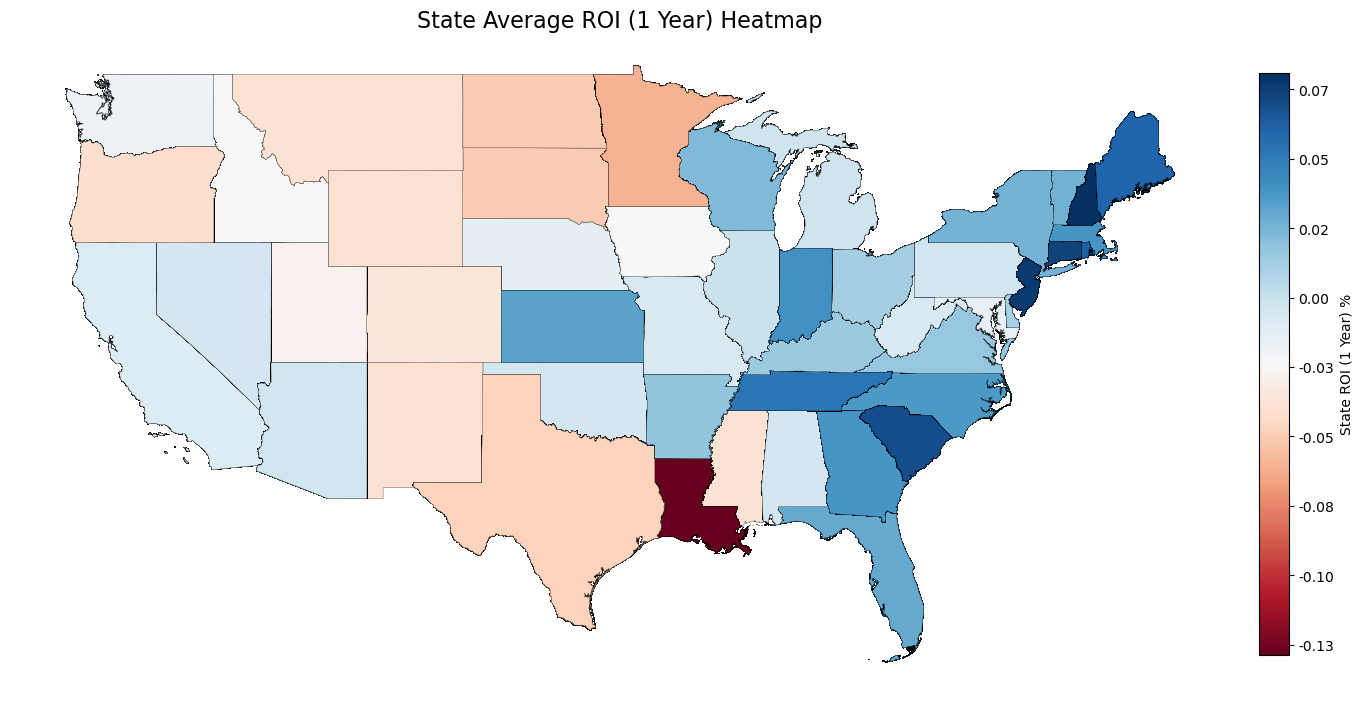

In [11]:
# Load the shapefile (USA map from the Census Bureau)
shapefile_path = r"C:\Users\willr\OneDrive\Desktop\STU_stuff\Data_An_631\Final_Proj\Data\shape_files\cb_2018_us_state_500k.shp"

# Store data in a GeoPandas DataFrame
us_states = gpd.read_file(shapefile_path)

# Clean and standardize state abbreviations
us_states['STUSPS'] = us_states['STUSPS'].str.strip().str.upper()
profit_df['State'] = profit_df['State'].str.strip().str.upper()

# Merge profit data with US states GeoDataFrame
df_maps = pd.merge(
    left=us_states,
    right=profit_df,
    left_on='STUSPS',
    right_on='State',
)

# Group by 'State' and calculate the average 'ROI_1YR (%)' for each state
state_roi = df_maps.groupby('State', as_index=False)['ROI_1YR (%)'].mean()
state_roi.rename(columns={'ROI_1YR (%)': 'state_ROI'}, inplace=True)

# Merge the state_ROI back into df_maps
df_maps = pd.merge(df_maps, state_roi, on='State')

# Exclude Alaska, Hawaii, and Puerto Rico
df_maps = df_maps[~df_maps['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Plot the map using GeoPandas' plot function without separate plt.figure()
ax = df_maps.plot(
    column='state_ROI',
    legend=True,
    cmap='RdBu',
    figsize=(15, 10),  # Set figure size directly here
    edgecolor='black',
    linewidth=0.2,
    legend_kwds={
        'label': "State ROI (1 Year) %",
        'orientation': "vertical",
        'shrink': 0.6,
        'format': '%.2f',
        'pad': 0.02
    }
)

# Turn off axis markers for clean display
ax.set_axis_off()

# Add a title
plt.title('State Average ROI (1 Year) Heatmap', fontsize=16)

# Adjust layout to avoid scroll bars
plt.tight_layout()

# Display the plot
plt.show()


In [12]:

# Used for interactive heat maps
# import folium                                      # Creating interactive maps
# from folium import Choropleth                      # Adding choropleth layers for color-coded maps
# import branca.colormap as cm                       # Creating and managing color maps for visualizations

# TIGER/Line Shapefiles + "Cartographic Boundary Files" 
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html -> look for a zip code map

# Load the shapefile
shapefile_path = r"C:\Users\willr\OneDrive\Desktop\STU_stuff\Data_An_631\Final_Proj\Data\shape_files\cb_2018_us_zcta510_500k\cb_2018_us_zcta510_500k.shp"
us_zip = gpd.read_file(shapefile_path)

# Ensure ZIP codes are strings with leading zeros
us_zip['ZCTA5CE10'] = us_zip['ZCTA5CE10'].astype(str).str.zfill(5)
profit_df['Zip_Code'] = profit_df['Zip_Code'].astype(str).str.zfill(5)

# Filter for NJ
nj_profit = profit_df[profit_df['State'] == 'NJ'].copy()

# Make a new column 'zip_ROI_1yr' that is grouped zip codes and produces a growth percentage
nj_profit.loc[:, 'zip_ROI_1yr'] = nj_profit.groupby('Zip_Code')['ROI_1YR (%)'].transform('mean')

# Merge the zip code shape file with filter df
nj_zip_map_df = pd.merge(us_zip, nj_profit, left_on='ZCTA5CE10', right_on='Zip_Code', how='inner')

# Validate and clean geometries
nj_zip_map_df = nj_zip_map_df[nj_zip_map_df['geometry'].notnull() & nj_zip_map_df['geometry'].is_valid & ~nj_zip_map_df['geometry'].is_empty]

# Convert GeoDataFrame to WGS84 CRS for folium
nj_zip_map_df = nj_zip_map_df.to_crs("EPSG:4326")

# Create a folium map centered around NJ
m = folium.Map(location=[40.0583, -74.4057], zoom_start=8)

# Create a color scale based on ROI values
min_roi = nj_zip_map_df['zip_ROI_1yr'].min()
max_roi = nj_zip_map_df['zip_ROI_1yr'].max()
colormap = cm.LinearColormap(colors=['red', 'yellow', 'green'], vmin=min_roi, vmax=max_roi, caption='ROI (1 Year)')

# Add ZIP code polygons to the map with choropleth coloring
for _, row in nj_zip_map_df.iterrows():
    # Convert geometry to GeoJSON
    geo_json = row['geometry'].__geo_interface__
    # Add GeoJSON with style based on zip_ROI_1yr
    folium.GeoJson(
        geo_json,
        tooltip=folium.Tooltip(f"ZIP Code: {row['Zip_Code']}<br>ROI (1 Year): {row['zip_ROI_1yr']:.2f}%", sticky=True),
        style_function=lambda x, roi=row['zip_ROI_1yr']: {
            'fillColor': colormap(roi),
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.6,
        }
    ).add_to(m)

# Add the color scale to the map
colormap.add_to(m)

# Save map to HTML
m.save('nj_zip_code_roi_heatmap.html')

# Display map in Jupyter (if applicable)
m


In [13]:
# Create a table with the top 5 ZIP codes based on highest zip_ROI_1yr
top_5_zip_codes = (
    nj_profit.groupby('Zip_Code')['zip_ROI_1yr']
    .mean()
    .reset_index()
    .sort_values(by='zip_ROI_1yr', ascending=False)
    .head(5)
)

# Rename columns for formatting
top_5_zip_codes.columns = ['Zip Code', 'ROI']

# Format the DataFrame as an HTML table
html_table = top_5_zip_codes.to_html(index=False, escape=False)

# Add custom CSS for bold headers and left-aligned columns
styled_table = f"""
<style>
    table {{border-collapse: collapse; width: 30%; margin: 20px auto;}}
    th {{font-weight: bold; text-align: left; background-color: #f2f2f2;}}
    td {{text-align: left;}}
    td, th {{border: 1px solid #ddd; padding: 8px;}}
</style>
{html_table}
"""

# Display the styled HTML table
display(HTML(styled_table))

Zip Code,ROI
08104,0.34
08609,0.34
08611,0.30
08103,0.27
08401,0.21
